In [3]:
################################
# Evaluating Regression Models #
################################
# install.packages("cv")
library(readr)
library(ggplot2)
library(e1071)
library(caret)
library(cv)

library(rpart)
library(randomForest)

In [5]:
## read data
NY_House_Dataset <- read_csv("NY-House-Dataset.csv")

dataset <- NY_House_Dataset

# clean- Keeps only the middle 98% of prices - 1% off bottom, 1% off top
dataset <- subset(dataset,
                  PRICE > quantile(PRICE, 0.01) &
                  PRICE < quantile(PRICE, 0.99) &
                  PROPERTYSQFT > quantile(PROPERTYSQFT, 0.01) &
                  PROPERTYSQFT < quantile(PROPERTYSQFT, 0.99))

dataset$log_price <- log10(dataset$PRICE)
dataset$log_sqft <- log10(dataset$PROPERTYSQFT)


## column names
names(dataset)

summary(dataset$PRICE)

summary(dataset$PROPERTYSQFT)

Rows: 4801 Columns: 17
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (11): BROKERTITLE, TYPE, ADDRESS, STATE, MAIN_ADDRESS, ADMINISTRATIVE_AR...
dbl  (6): PRICE, BEDS, BATH, PROPERTYSQFT, LATITUDE, LONGITUDE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "BROKERTITLE"                 "TYPE"                       
 [3] "PRICE"                       "BEDS"                       
 [5] "BATH"                        "PROPERTYSQFT"               
 [7] "ADDRESS"                     "STATE"                      
 [9] "MAIN_ADDRESS"                "ADMINISTRATIVE_AREA_LEVEL_2"
[11] "LOCALITY"                    "SUBLOCALITY"                
[13] "STREET_NAME"                 "LONG_NAME"                  
[15] "FORMATTED_ADDRESS"           "LATITUDE"                   
[17] "LONGITUDE"                   "log_price"                  
[19] "log_sqft"

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  136999   499900   825000  1547562  1450000 21500000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    462    1215    2184    2023    2184    9026 

In [7]:
# train and test sets
index <- sample(nrow(dataset), floor(0.8 * nrow(dataset)))
train <- dataset[index, ]
test <- dataset[-index, ]

dim(train)
dim(test)

[1] 3700   19

[1] 925  19

### models

R RNG seed set to 125582



10-Fold Cross Validation
method: Woodbury
criterion: mse
cross-validation criterion = 0.113009
bias-adjusted cross-validation criterion = 0.1130068
95% CI for bias-adjusted CV criterion = (0.1071176, 0.118896)
full-sample criterion = 0.1129672


`geom_smooth()` using formula = 'y ~ x'


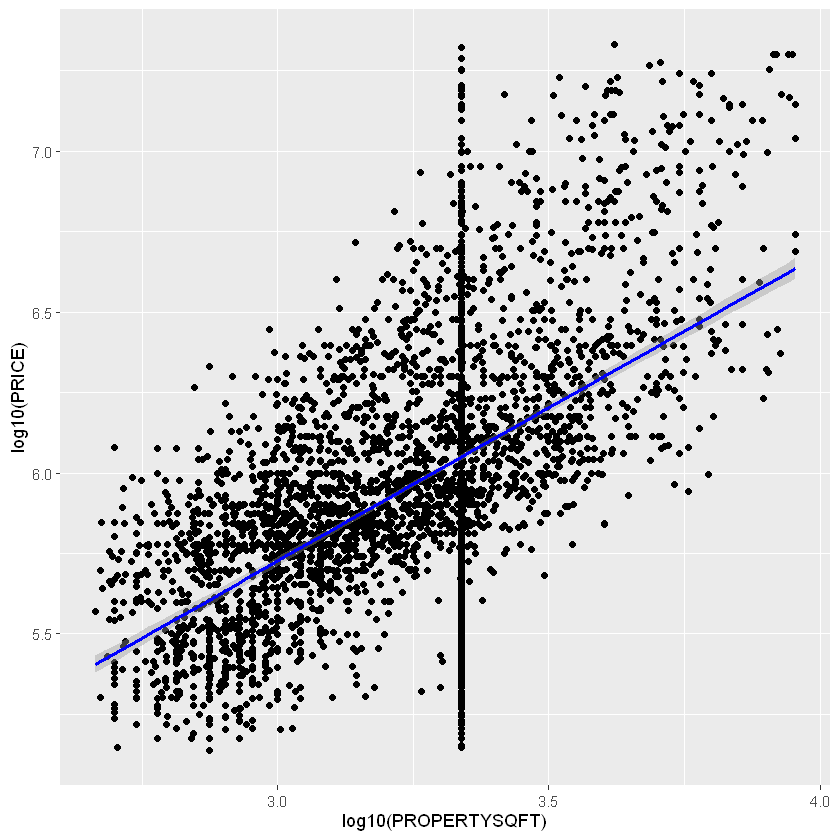

[1] 0.259436

[1] 0.1100283

[1] 0.3317051

mae,mse,rmse
<dbl>,<dbl>,<dbl>
0.259436,0.1100283,0.3317051


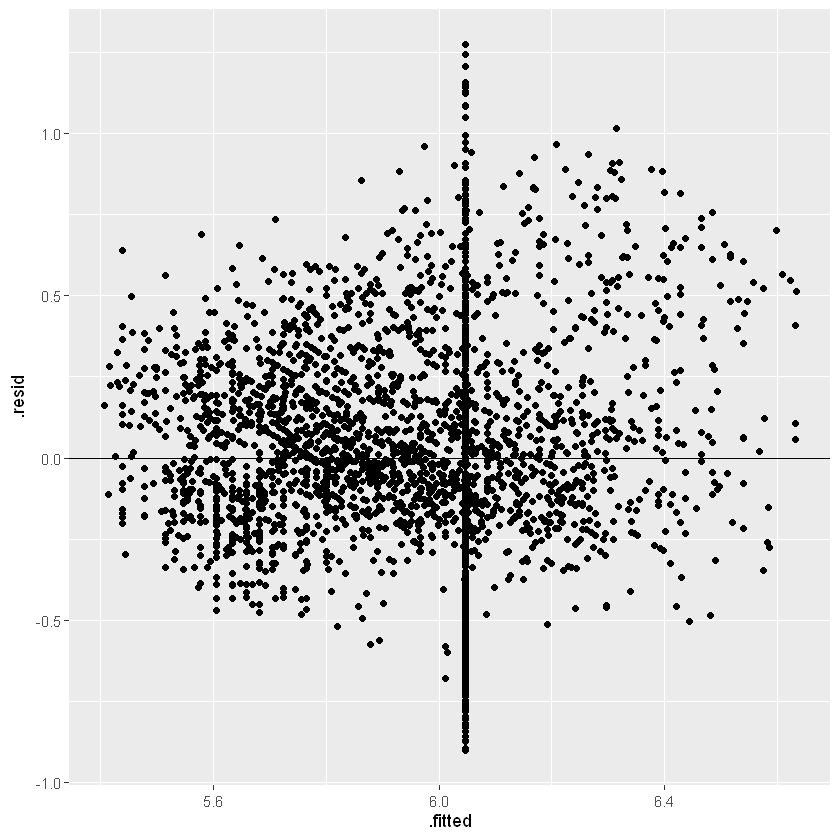

In [14]:
# --- Model 1: Linear Regression ---
lin.mod0 <- lm(log_price ~ log_sqft, data = train)

## Use CV function to run 
cv.res <- cv(lin.mod0)
summary(cv.res)

lm.pred0 <- predict(lin.mod0, test)

ggplot(dataset, aes(x = log10(PROPERTYSQFT), y = log10(PRICE))) +
  geom_point() +
  stat_smooth(method = "lm", col="blue")

ggplot(lin.mod0, aes(x = .fitted, y = .resid)) +
  geom_point() +
  geom_hline(yintercept = 0)

# ERROR
err <- lm.pred0-log10(test$PRICE)

# MAE
abs.err <- abs(err)                                                                
mean.abs.err <- mean(abs.err)
mean.abs.err

# MSE 
sq.err <- err^2              
mean.sq.err <- mean(sq.err)
mean.sq.err

# RMSE
root.mean.sq.err <- sqrt(mean.sq.err)
root.mean.sq.err

# Collect (the example stores MAE/MSE/RMSE in vectors, then averages)
mae0  <- c(mean.abs.err)                                                           
mse0  <- c(mean.sq.err)
rmse0 <- c(root.mean.sq.err)

results0 <- data.frame(mae = mean(mae0), mse = mean(mse0), rmse = mean(rmse0))    
results0

[1] 0.2510515

[1] 0.1025047

[1] 0.3201635

mae,mse,rmse
<dbl>,<dbl>,<dbl>
0.2510515,0.1025047,0.3201635


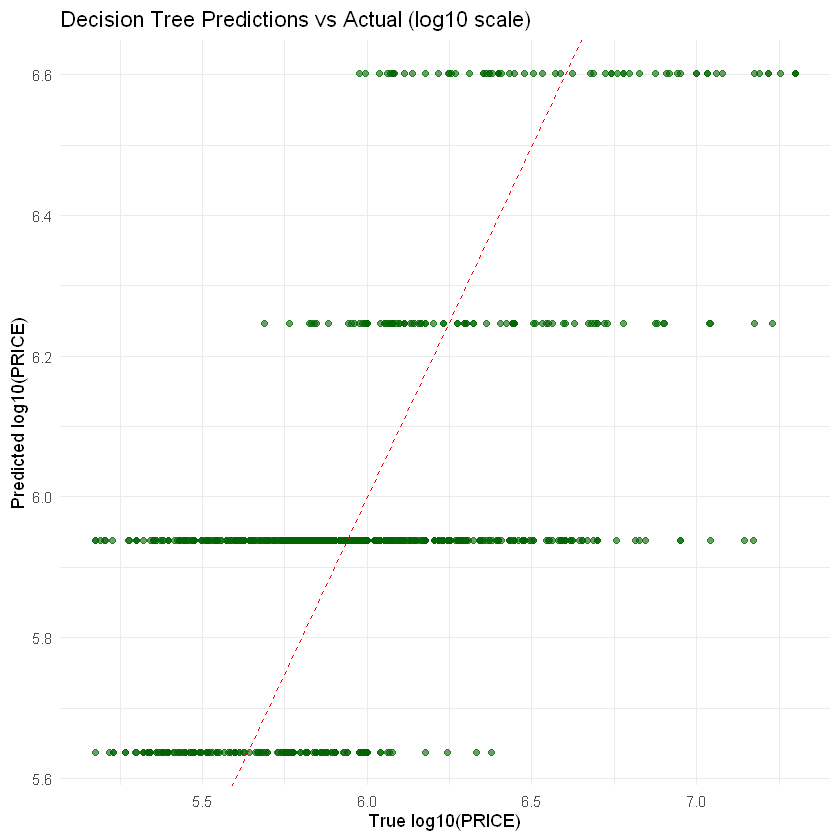

In [16]:
# --- Model 2: Decision Tree ---
tree.mod1 <- rpart(log_price ~ log_sqft, data = train)

tree.pred1 <- predict(tree.mod1, newdata = test)

ggplot(data.frame(True = log10(test$PRICE), Predicted = tree.pred1),
       aes(x = True, y = Predicted)) +
  geom_point(alpha = 0.6, color = "darkgreen") +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(title = "Decision Tree Predictions vs Actual (log10 scale)",
       x = "True log10(PRICE)",
       y = "Predicted log10(PRICE)") +
  theme_minimal()

# ERROR
err <- tree.pred1-log10(test$PRICE)

# MAE
abs.err <- abs(err)                                                                
mean.abs.err <- mean(abs.err)
mean.abs.err

# MSE 
sq.err <- err^2              
mean.sq.err <- mean(sq.err)
mean.sq.err

# RMSE
root.mean.sq.err <- sqrt(mean.sq.err)
root.mean.sq.err

# Collect (the example stores MAE/MSE/RMSE in vectors, then averages)
mae1  <- c(mean.abs.err)                                                           
mse1  <- c(mean.sq.err)
rmse1 <- c(root.mean.sq.err)

results1 <- data.frame(mae = mean(mae1), mse = mean(mse1), rmse = mean(rmse1))    
results1

[1] 0.2554139

[1] 0.1089267

[1] 0.3300404

mae,mse,rmse
<dbl>,<dbl>,<dbl>
0.2554139,0.1089267,0.3300404


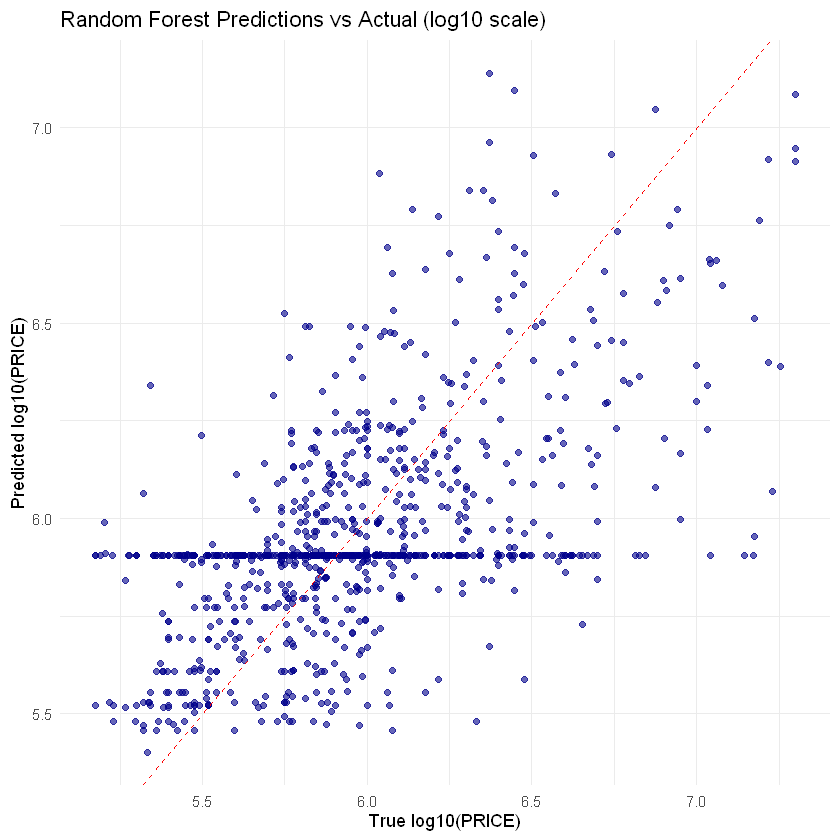

In [18]:
# --- Model 3: Random Forest ---
rf_mod2 <- randomForest(log_price ~ log_sqft, data = train)


rf_pred2 <- predict(rf_mod2, test)

ggplot(data.frame(True = log10(test$PRICE), Predicted = rf_pred2),
       aes(x = True, y = Predicted)) +
  geom_point(alpha = 0.6, color = "darkblue") +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(title = "Random Forest Predictions vs Actual (log10 scale)",
       x = "True log10(PRICE)",
       y = "Predicted log10(PRICE)") +
  theme_minimal()

# ERROR
err <- rf_pred2-log10(test$PRICE)

# MAE
abs.err <- abs(err)                                                                
mean.abs.err <- mean(abs.err)
mean.abs.err

# MSE 
sq.err <- err^2              
mean.sq.err <- mean(sq.err)
mean.sq.err

# RMSE
root.mean.sq.err <- sqrt(mean.sq.err)
root.mean.sq.err

# Collect (the example stores MAE/MSE/RMSE in vectors, then averages)
mae2  <- c(mean.abs.err)                                                           
mse2  <- c(mean.sq.err)
rmse2 <- c(root.mean.sq.err)

results1 <- data.frame(mae = mean(mae2), mse = mean(mse2), rmse = mean(rmse2))    
results1